In [1]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.HEP.NEWPHYSICS/master/init.py
import init; init.init(force_download=False);

# Asymptotic formulae for likelihood-based tests of new physics

https://arxiv.org/abs/1007.1727

Section 2 describes how to build a histogram $\mathbf{n}=(n_1,...,n_N)$ from measuring a variable $x$ which is composed of a background and signal component. Each component distribution is predicted by some theory. A parameter $\mu \in [0,1]$ represents the degree of presence of signal ($\mu=0 \rightarrow$ only background, $\mu=1 \rightarrow$ signal + background).

We assume we make the process of bulding histograms many times and, thus, we have a distribution of histograms. The expected value of the unmber of measurements contained in bin $n_i$ can be written as:

$$\begin{equation*}
\mathbb{E}[n_i] = \mu s_i + b_i
\end{equation*}
\tag{1}
$$

and the mean number of entries of signal and background are:


$$\begin{equation*}
s_i = s_\text{tot}\int_{\text{bin }i} f_s(x;\boldsymbol{\theta}_s)dx\\
b_i = b_\text{tot}\int_{\text{bin }i} f_b(x;\boldsymbol{\theta}_b)dx
\end{equation*}
\tag{2}
$$

where

- $s_\text{tot}, b_\text{tot} \in [0,1]$ and $s_\text{tot}+b_\text{tot}=1$ is the porcentage of measurements coming from the signal and from the background respectively.
- $f_s(x;\boldsymbol{\theta}_s)$ and $f_b(x;\boldsymbol{\theta}_b)$ are the $pdf$'s for variable $x$ as coming from signal or background

finally, the distribution of each bin is given by a Poisson variable


$$\begin{equation*}
n_i \sim \text{Poisson}(\lambda_i) \;\;\; \text{ with } \lambda_i=\mu s_i + b_i\\
P(n_i; \mu, \boldsymbol{\theta}_s, \boldsymbol{\theta}_b, s_\text{tot}, b_\text{tot}) = P(n_i; \mu, \boldsymbol{\theta}, s_\text{tot} ) = \frac{\lambda_i^{n_i}}{n_i!}e^{-\lambda_i} = \frac{(\mu s_i + b_i)^{n_i}}{n_i!}e^{-\mu s_i + b_i}
\end{equation*}
\tag{3}
$$

with $\boldsymbol{\theta} = (\boldsymbol{\theta}_s, \boldsymbol{\theta}_b, b_\text{tot})$, assuming $s_\text{tot}$ is fixed given by the theory and focusing on $\mu$.

observe that for any random variable $Z \sim \text{Poisson}(\lambda)$ its expected value $\mathbb{E}[Z]=\lambda$ (see [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) and, since the random variable associated with each bin $n_i\sim \text{Poisson}(\lambda_i)$, then $\mathbb{E}[n_i] = \lambda_i = \mu s_i + b_i$

### background and signal distributions

In this notebook, we **assume** background and signal distributions are the following

- $b \sim \text{exp}(t)$ with pdf $f_b(x;\boldsymbol{\theta}_b)$ and   $\boldsymbol{\theta}_b=(t)\;\;\;\;$ we use $t$ instead of $\lambda$ as customary for the Exponential distribuion for convinience in Python code
- $s \sim \mathcal{N}(\mu_s, \sigma_s)$ with pdf $f_s(x;\boldsymbol{\theta}_s)$ and $\boldsymbol{\theta}_s=(\mu_s, \sigma_s)$

Also, a specification of $N$ bins is given in `bin_edges` $\in \mathbb{R}^{N+1}$


### log likelihood

for the moment we try to estimate $\mu$ assuming all the rest of parameters $ (\boldsymbol{\theta}, s_\text{tot}) $ are fixed.

Given **one** observed histogram, the log likelihood of a given $\mu$ is given by:


$$\mathcal{L}(\mu) = \log \prod_{i=1}^N \frac{(\mu s_i + b_i)^{\overline{n_i}}}{\overline{n_i}!}e^{-\mu s_i + b_i} =  \sum_{i=1}^N \overline{n_i} \log  (\mu s_i + b_i) - \log (\overline{n_i}!)-\mu s_i - b_i$$

where $\overline{n_i}$ is the observed count in bin $i$, and we want:


$$\text{MLE}(\mu) = \underset{\mu}{\text{arg max}} \;\;\mathcal{L}(\mu) $$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from progressbar import progressbar as pbar
from local.lib import histos2d as h2d
from scipy import stats
from scipy.optimize import minimize
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
n_bins = 20
bin_edges = np.r_[list(np.linspace(0,180,n_bins))+[np.inf]]
bin_edges

array([  0.        ,   9.47368421,  18.94736842,  28.42105263,
        37.89473684,  47.36842105,  56.84210526,  66.31578947,
        75.78947368,  85.26315789,  94.73684211, 104.21052632,
       113.68421053, 123.15789474, 132.63157895, 142.10526316,
       151.57894737, 161.05263158, 170.52631579, 180.        ,
                inf])

# an experiment set with certain parameter values

In [3]:
bh = h2d.BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=100, btot=1000, bin_edges=bin_edges)

### some sampled histograms

100% (3 of 3) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


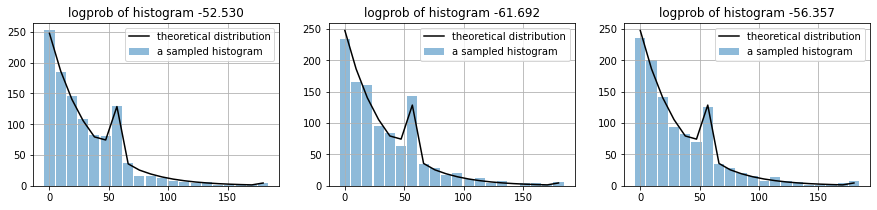

In [4]:
sn,ss,sb = bh.rvs(3)
plt.figure(figsize=(5*len(sn),3))
for i in range(len(sn)):
    plt.subplot(1,len(sn),i+1)
    observed_histogram = sn.values[i]
    bh.plot_histogram(observed_histogram)

In [5]:
observed_histogram

array([236., 201., 141.,  93.,  83.,  70., 125.,  35.,  29.,  21.,  15.,
         8.,  14.,   7.,   6.,   1.,   2.,   2.,   4.,   7.])

### logprog param sensitivity for a histogram from the SAME distribution

how logprob of a sampled histogram changes as the params change

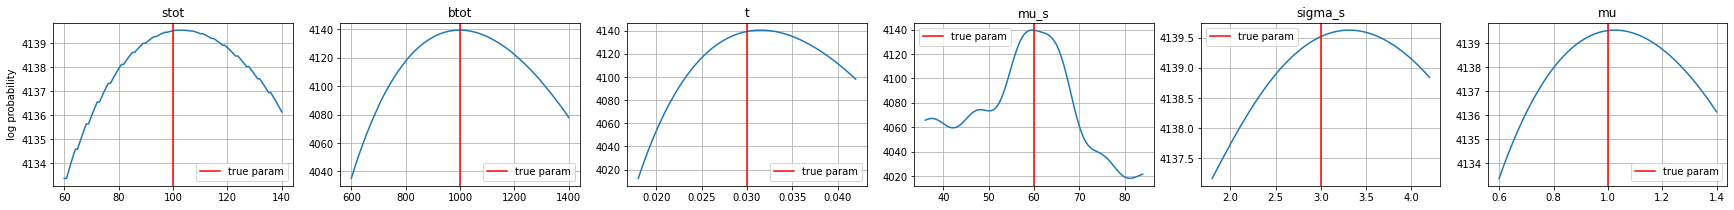

In [7]:
observed_histogram = sn.values[0]
bh.plot_logprob_param_sensitivity(observed_histogram, use_plog=True)

### logprog param sensitivity for a histogram from a DIFFERENT distribution

slightly change one param for the new distribution

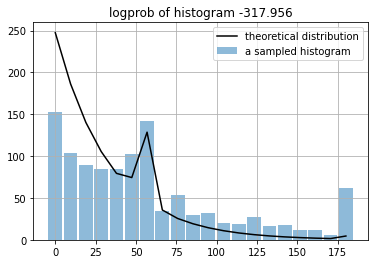

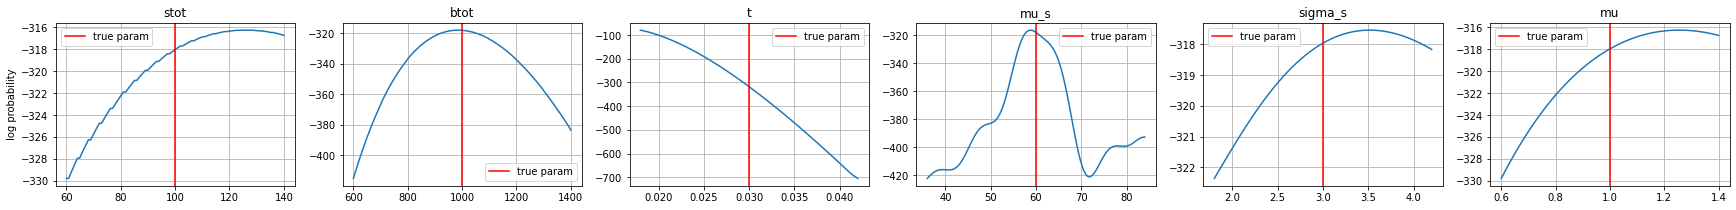

In [8]:
observed_histogram2 = bh.clone(t=bh.t*.5).rvs(1)[0].values[0]
bh.plot_histogram(observed_histogram2)
bh.plot_logprob_param_sensitivity(observed_histogram2)

for a slight change on another parameter

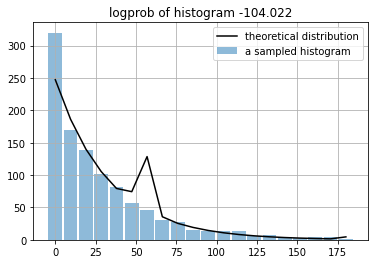

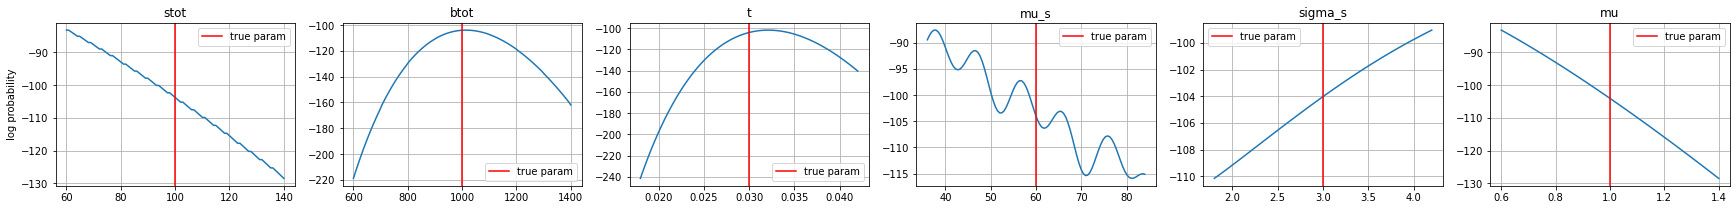

In [13]:
observed_histogram2 = bh.clone(mu_s=1).rvs(1)[0].values[0]
bh.plot_histogram(observed_histogram2)
bh.plot_logprob_param_sensitivity(observed_histogram2)

# Maximum likelihood estimation

### sample a `observed_histogram`

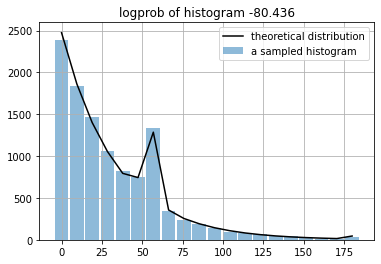

In [9]:
bh = h2d.BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
sn,ss,sb = bh.rvs(1)
observed_histogram = sn.values[0]
bh.plot_histogram(observed_histogram)

### MLE estimate $\mu$ 

very stable

In [10]:
bh = h2d.BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "btot", "mu_s", "sigma_s", "t"], observed_histogram=observed_histogram, verbose=True)

0.35611078404289187
0.0
fixed params     {'stot': 1000, 'btot': 10000, 'mu_s': 60.0, 'sigma_s': 3.0, 't': 0.03}
allowable paramss ranges  {'mu_s': [0.0, 180.0], 'sigma_s': [0.001, 10], 'btot': [0, 11000.0], 'stot': [0, 11000.0], 't': [0.001, 10], 'mu': [0, 10]}
init params      {'mu': 0.6958773114574468}
optimized params {'mu': 1.0519880955003387}
expected params  {'mu': 1.0}

coordinate_descent_result(coord_success=[True], coord_messages=['Optimization terminated successfully.'], x=array([1.0519881]), x_history=array([[0.69587731],
       [1.0519881 ],
       [1.0519881 ]]), success=True, message='finished after 2 iterations and convergence reached at 1e-09 tol')


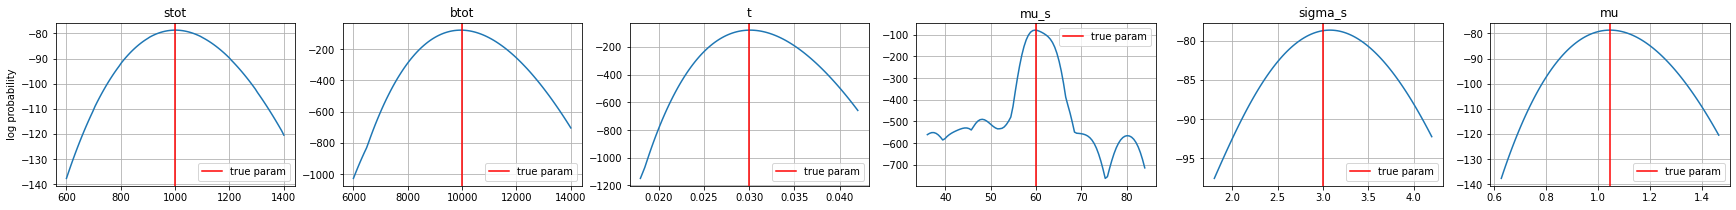

In [7]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

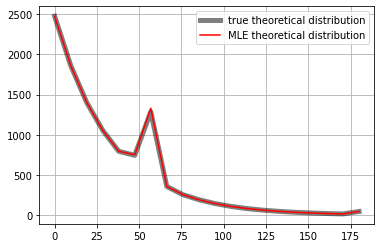

In [8]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate $\mu$ AND $t$

somewhat unstable, even if optimization ends successfully estimated params are sometimes not correct

In [12]:
bh = h2d.BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "btot", "mu_s", "sigma_s"], observed_histogram=observed_histogram, verbose=True,
                                       method="BFGS")

0.14182609421490167
0.0
fixed params     {'stot': 1000, 'btot': 10000, 'mu_s': 60.0, 'sigma_s': 3.0}
allowable paramss ranges  {'mu_s': [0.0, 180.0], 'sigma_s': [0.001, 10], 'btot': [0, 11000.0], 'stot': [0, 11000.0], 't': [0.001, 10], 'mu': [0, 10]}
init params      {'t': 5.758377735191788, 'mu': 4.709467845067101}
optimized params {'t': 5.758377735191788, 'mu': 4.567641750852199}
expected params  {'t': 0.03, 'mu': 1.0}

coordinate_descent_result(coord_success=[True, True], coord_messages=['Optimization terminated successfully.', 'Optimization terminated successfully.'], x=array([5.75837774, 4.56764175]), x_history=array([[5.75837774, 4.70946785],
       [5.75837774, 4.56764175],
       [5.75837774, 4.56764175]]), success=True, message='finished after 2 iterations and convergence reached at 1e-09 tol')


In [19]:
bh = h2d.BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "btot", "mu_s", "sigma_s"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'btot': 10000, 'mu_s': 60.0, 'sigma_s': 3.0}
allowable paramss ranges  {'mu_s': [0.0, 180.0], 'sigma_s': [0.001, 10], 'btot': [0, 11000.0], 'stot': [0, 11000.0], 't': [0.001, 10], 'mu': [0, 10]}
init params      {'t': 0.06186974437261224, 'mu': 0.24364153380632136}
optimized params {'t': 0.029978376103850166, 'mu': 0.9681875899155266}
expected params  {'t': 0.03, 'mu': 1.0}

 final_simplex: (array([[0.02997838, 0.96818759],
       [0.02997823, 0.96813547],
       [0.02997851, 0.96811091]]), array([-66250.22804343, -66250.22804288, -66250.22804208]))
           fun: -66250.22804343066
       message: 'Optimization terminated successfully.'
          nfev: 92
           nit: 49
        status: 0
       success: True
             x: array([0.02997838, 0.96818759])


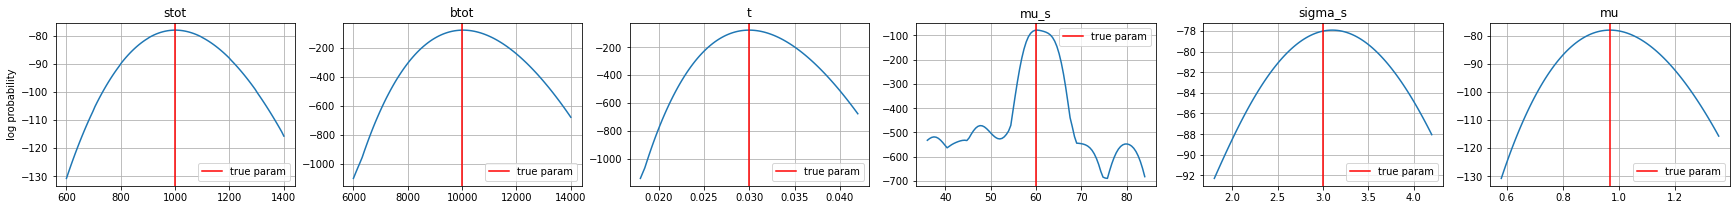

In [17]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

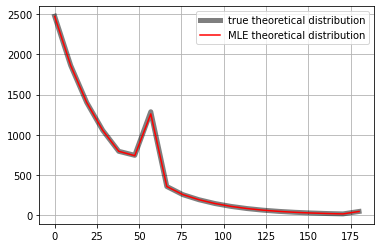

In [18]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate $\mathcal{L}(\mu, \hat{\hat{\mathbf{\theta}}})\;\;$,  for a fixed $\mu$ (the true one), and optimizing for $t$, $b_{tot}$, $\mu_s$, $\sigma_s$

optimization **moves very little** from the initial params, probably due to flat regions in params space, mostly on $\mu_s$


In [13]:
bh = h2d.BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
self = bh

In [14]:
params_names = ["btot", "mu", "mu_s", "sigma_s", "t"]
vals = self.get_random_params(observed_histogram, params_names)
x0 = {k:v for k,v in zip(params_names, vals)}
x0

{'btot': 6808.014402538625,
 'mu': 8.771695006979801,
 'mu_s': 56.31367952498265,
 'sigma_s': 3.1496727714726243,
 't': 0.6000335963620977}

In [15]:
self.stot

1000

In [37]:
param_to_optimize = "t"
fixed_params = [i for i in self.params.keys() if i!=param_to_optimize]
print (fixed_params)
th = h2d.BShist_distribution(**x0, stot=self.stot, bin_edges=bin_edges)
optimized_params, optimized_bh = th.MLE(fixed_params = fixed_params, observed_histogram=observed_histogram, verbose=True)

['stot', 'btot', 'mu_s', 'sigma_s', 'mu']
fixed params     {'stot': 1000, 'btot': 6808, 'mu_s': 56.31367952498265, 'sigma_s': 3.1496727714726243, 'mu': 8.771695006979801}
allowable paramss ranges  {'mu_s': [0.0, 180.0], 'sigma_s': [0.001, 10], 'btot': [0, 11000.0], 'stot': [0, 11000.0], 't': [0.001, 10], 'mu': [0, 10]}
init params      {'t': 7.241112319942615}
optimized params {'t': 7.241112319942615}
expected params  {'t': 0.6000335963620977}

coordinate_descent_result(coord_success=[True], coord_messages=['Optimization terminated successfully.'], x=array([7.24111232]), x_history=array([[7.24111232],
       [7.24111232]]), success=True, message='finished after 1 iterations and convergence reached at 1e-09 tol')


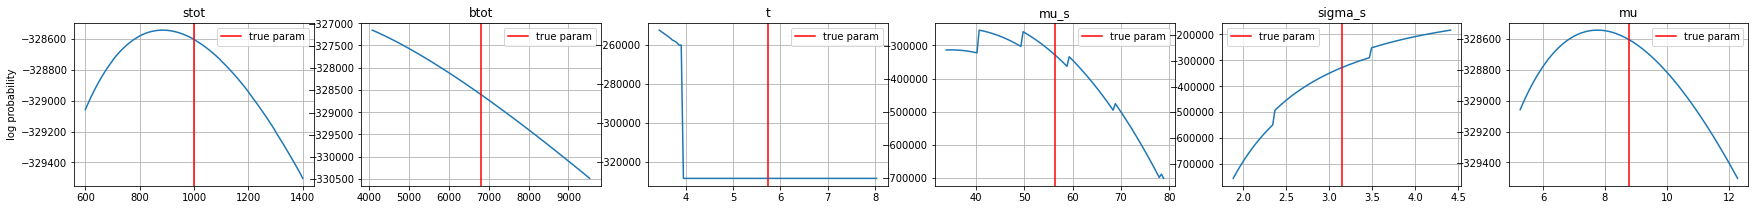

In [35]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram, use_plog=True)

In [64]:
param_to_optimize = "t"
fixed_params = [i for i in self.params.keys() if i!=param_to_optimize]
print (fixed_params)
th = h2d.BShist_distribution(**x0, stot=self.stot, bin_edges=bin_edges)
optimized_params, optimized_bh = th.MLE(fixed_params = fixed_params, observed_histogram=observed_histogram, verbose=True)

['stot', 'btot', 'mu_s', 'sigma_s', 'mu']
fixed params     {'stot': 1000, 'btot': 9516, 'mu_s': 52.61299732191162, 'sigma_s': 3.2791588525713533, 'mu': 5.317606058076274}
allowable paramss ranges  {'mu_s': [0.0, 180.0], 'sigma_s': [0.001, 10], 'btot': [0, 11000.0], 'stot': [0, 11000.0], 't': [0.001, 10], 'mu': [0, 10]}
init params      {'t': 1.6595803885049922}
optimized params {'t': -0.03074234911567645}
expected params  {'t': 1.047178947411954}

 final_simplex: (array([[-0.03074235],
       [-0.03074741]]), array([-63241.6848805 , -63241.68482952]))
           fun: -63241.68488050215
       message: 'Optimization terminated successfully.'
          nfev: 49
           nit: 24
        status: 0
       success: True
             x: array([-0.03074235])


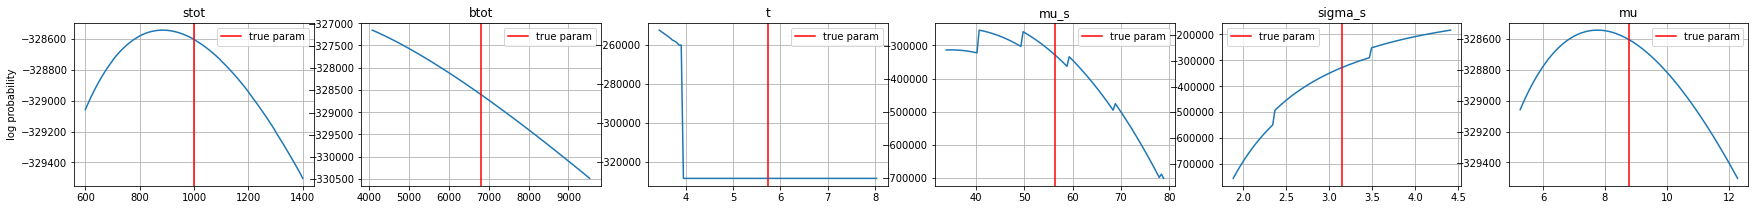

In [34]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram, use_plog=True)

In [21]:
bh = h2d.BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "mu"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'mu': 1.0}
allowable paramss ranges  {'mu_s': [0.0, 180.0], 'sigma_s': [0.001, 10], 'btot': [0, 11000.0], 'stot': [0, 11000.0], 't': [0.001, 10], 'mu': [0, 10]}
init params      {'btot': 5685.995624959749, 't': 5.137083009691973, 'mu_s': 86.53087077526904, 'sigma_s': 2.543382421793397}
optimized params {'btot': 10366.00000505737, 't': 0.02804522889643675, 'mu_s': 37.48118471683361, 'sigma_s': 2.7552265212242344}
expected params  {'btot': 10000, 't': 0.03, 'mu_s': 60.0, 'sigma_s': 3.0}

 final_simplex: (array([[1.03660000e+04, 2.80452289e-02, 3.74811847e+01, 2.75522652e+00],
       [1.03660001e+04, 2.80451991e-02, 3.74812079e+01, 2.75522551e+00],
       [1.03660001e+04, 2.80452642e-02, 3.74812262e+01, 2.75522472e+00],
       [1.03660001e+04, 2.80451882e-02, 3.74811938e+01, 2.75522608e+00],
       [1.03660001e+04, 2.80452022e-02, 3.74812697e+01, 2.75522287e+00]]), array([-65567.07731451, -65567.07731446, -65567.07731444, -65567.07731441,
       -65567.0773

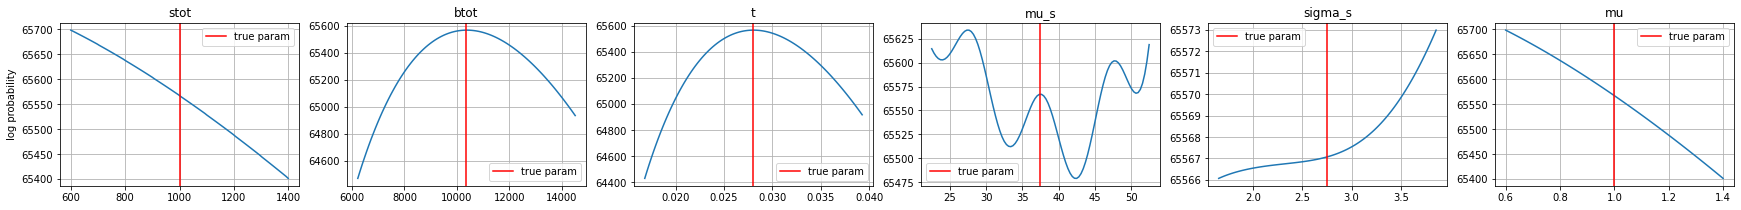

In [22]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram, use_plog=True)

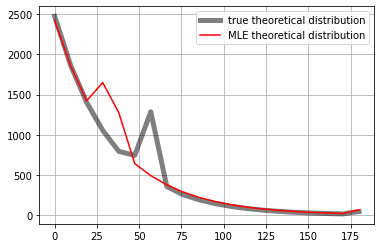

In [23]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate $\mathcal{L}(\hat{\mu}, \hat{\mathbf{\theta}})\;\;$ optimizing for $\mu$, $t$, $b_{tot}$, $\mu_s$, $\sigma_s$

similar to above

In [89]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000}
init params      {'btot': 178321.29046321864, 't': 0.5349638713896558, 'mu_s': 1069.9277427793118, 'sigma_s': 53.49638713896559, 'mu': 17.832129046321864}
optimized params {'btot': 185957.13405165705, 't': 0.4830729003169886, 'mu_s': 1097.3330196039044, 'sigma_s': 54.74171194261381, 'mu': 18.18067266782943}
expected params  {'btot': 10000, 't': 0.03, 'mu_s': 60.0, 'sigma_s': 3.0, 'mu': 1.0}

 final_simplex: (array([[1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417119e+01,
        1.81806727e+01],
       [1.85957134e+05, 4.83072900e-01, 1.09733302e+03, 5.47417120e+01,

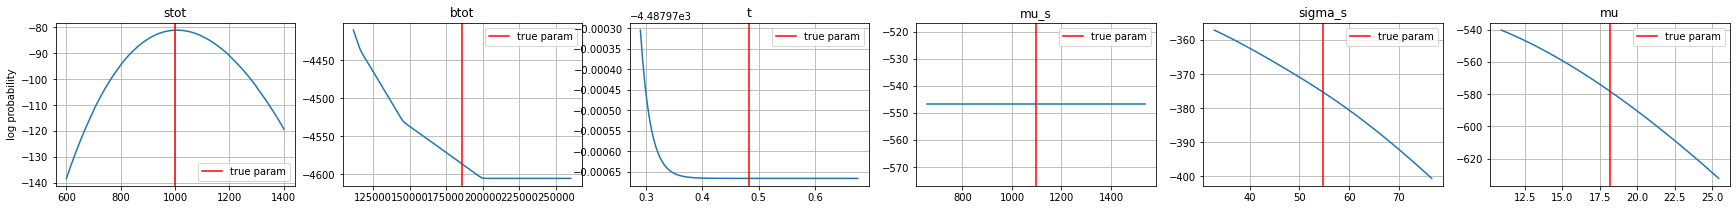

In [90]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

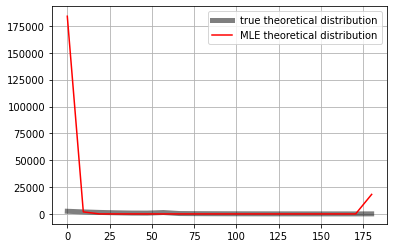

In [91]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate  for a fixed $\mu_s$ (the true ones), and optimizing for $t$, $\mu$, $b_{tot}$, $s_\mu$, $s_\sigma$

optimization still unstable but not so much

In [92]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "mu_s"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'mu_s': 60.0}
init params      {'btot': 192679.46489060958, 't': 0.5780383946718287, 'sigma_s': 57.80383946718287, 'mu': 19.267946489060957}
optimized params {'btot': 335955.6407830629, 't': 0.5595486043184865, 'sigma_s': 37.66975683866792, 'mu': 4.731580758874627}
expected params  {'btot': 10000, 't': 0.03, 'sigma_s': 3.0, 'mu': 1.0}

 final_simplex: (array([[3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00],
       [3.35955641e+05, 5.59548604e-01, 3.76697568e+01, 4.73158076e+00]]), array([1399.75138326, 1399.75138326, 1399.75138326, 1399.75138326,
       1399.75138326]))
           fun: 1399.7513832619932
       message: 'Optimization terminated successfully.'
          nfev: 350
           nit: 188
        status: 0
      

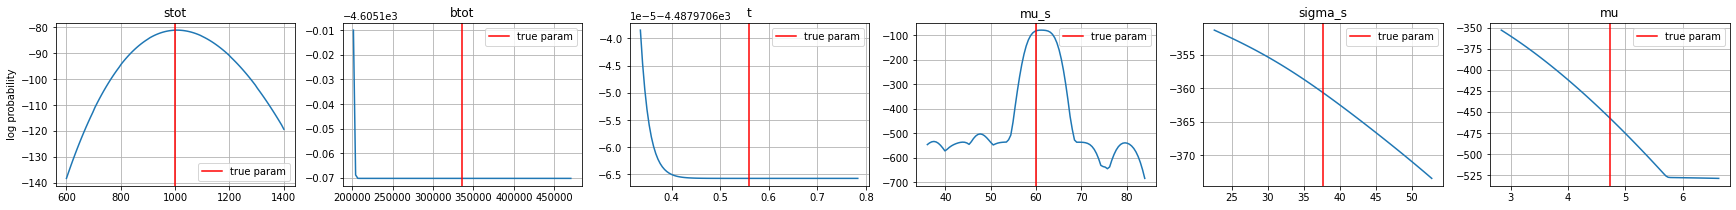

In [93]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

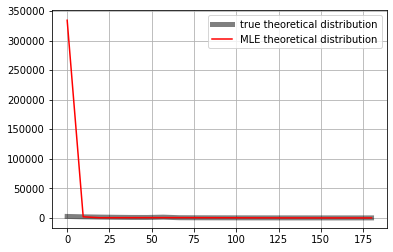

In [94]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

### MLE estimate  for a fixed $\mu_s$ (the true ones), and optimizing for $t$, $\mu$, $b_{tot}$, $s_\mu$, $s_\sigma$ using Gaussian aprox to Poisson

seems to work better ocassionally, at least partially, failing to estimate $\mu_s$ and $\sigma_s$ (too wide $\sigma_s$ equiv. to no signal)

In [115]:
bh = BShist_distribution(t=0.03, mu_s=60, sigma_s=3, mu=1, stot=1000, btot=10000, bin_edges=bin_edges, use_gaussian_appoximation=True)
optimized_params, optimized_bh = bh.MLE(fixed_params = ["stot", "mu_s"], observed_histogram=observed_histogram, verbose=True)

fixed params     {'stot': 1000, 'mu_s': 60.0}
init params      {'btot': 90581.75919405736, 't': 0.27174527758217204, 'sigma_s': 27.17452775821721, 'mu': 9.058175919405736}
optimized params {'btot': -9991.000141763547, 't': 0.03005302415769282, 'sigma_s': 43.71742652849895, 'mu': 0.19376488715229634}
expected params  {'btot': 10000, 't': 0.03, 'sigma_s': 3.0, 'mu': 1.0}

 final_simplex: (array([[-9.99100014e+03,  3.00530242e-02,  4.37174265e+01,
         1.93764887e-01],
       [-9.99100024e+03,  3.00530391e-02,  4.37174250e+01,
         1.93766390e-01],
       [-9.99100010e+03,  3.00530397e-02,  4.37174237e+01,
         1.93761786e-01],
       [-9.99100017e+03,  3.00530586e-02,  4.37174211e+01,
         1.93761294e-01],
       [-9.99100020e+03,  3.00529879e-02,  4.37174282e+01,
         1.93752922e-01]]), array([316.49103415, 316.49103415, 316.49103415, 316.49103415,
       316.49103416]))
           fun: 316.4910341450409
       message: 'Optimization terminated successfully.'
       

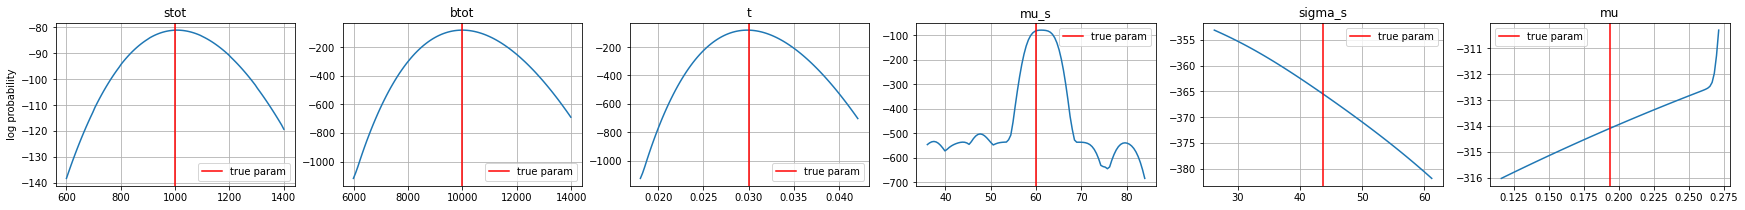

In [116]:
optimized_bh.plot_logprob_param_sensitivity(observed_histogram)

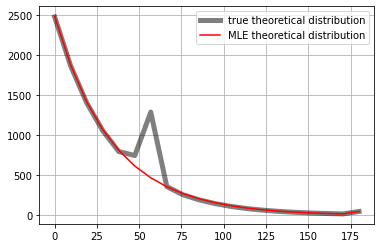

In [117]:
bh.plot_theoretical_distribution(label_prefix="true ", color="black", alpha=.5, lw=5)
optimized_bh.plot_theoretical_distribution(label_prefix="MLE ", color="red")
plt.grid(); plt.legend();

In [ ]:
def coordinate_descent_minimize(f, x0, max_iters=10, max_tol=1e-9, **kw_minimize_args):
    """
    coordinate descent minimization, using scipy.minimize for each coordinate in 
    consecutive order while fixing the rest.
    
    f,x0: just like scipy.minimize
    max_iter: maximum number of iterations. each iteration will loop over all coordinates
              calling scipy.minimize each time.
    max_tol:  maximum solution vector change under which iterations will continue until 
              reaching max_iter. if the change of the solution vector in consecutive 
              iterations is <max_tol optimization will finish.
              
    returns:  a dict object with optimization information. "x" will contain the final solution.
    
    """
    x = np.r_[x0].copy()
    x_hist = [x.copy()]
    message = "reached max_iters=%d"%max_iters
    for t in range(max_iters):        
        last_x = x.copy()
        rset = []
        for i in range(len(x)):
            def fi(xi):
                x[i] = xi
                return f(x)
            r = minimize(fi, x[i], **kw_minimize_args)
            x[i] = r.x
            rset.append(r)
        x_hist.append(x.copy())
        print (np.linalg.norm(x-last_x) )
        if np.linalg.norm(x-last_x) < max_tol:
            message = "finished after %s iterations and convergence reached at %1.e tol"%(t+1,max_tol)
            break
    ret = {"coord_success": [r.success for r in rset],
           "coord_messages": [r.message for r in rset],
           "x": x,
           "x_history": np.r_[x_hist],
           "success": np.alltrue([r.success for r in rset]),
           "message": message}

    rs = namedtuple("coordinate_descent_result",  " ".join(list(ret.keys())))
    ret = rs(**ret)
    return ret
    
